# **Project Title: Amazon Delivery Time Prediction**

### **Problem Statement:**
To predict delivery times for e-commerce orders based on a variety of factors such as product size, distance, traffic conditions, and shipping method.

### **Summary:**

This project aimed to build a machine learning–based prediction system to estimate Amazon delivery times using real-world features such as distance, weather, traffic, agent details, and order information.

The project workflow included:

Data Preparation: Cleaning the dataset, handling missing values, and removing irrelevant columns (like raw coordinates).

Feature Engineering: Creating useful features such as Distance_km, Order_Hour, Order_Day, Order_Month, Order_Weekday, and Order_Year.

Exploratory Data Analysis (EDA): Understanding how distance, traffic, weather, and agent performance affect delivery times.

Model Development: Training multiple regression models (Linear Regression, Random Forest, Gradient Boosting, XGBoost) and evaluating them using metrics like RMSE, MAE, and R².

Pipeline & MLflow Tracking: Building a preprocessing + model pipeline that handles categorical encoding, missing value imputation, and numeric scaling automatically.

Application Development: Deploying a Streamlit app that allows users to input order details and get a predicted delivery time.

Deployment: Preparing the app with a requirements.txt for easy deployment on Streamlit Cloud or local use.

## **Imports**

In [31]:
import pandas as pd

from math import radians, sin, cos, sqrt, atan2
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import mlflow
import mlflow.sklearn

import joblib

## **Data Loading and first look**

In [32]:
df = pd.read_csv("data/amazon_delivery.csv")
display(df.head())

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [33]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


None

,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Delivery_Time
count,43739.000000,43685.000000,43739.000000,43739.000000,43739.000000,43739.000000,43739.000000
mean,29.567137,4.633780,17.210960,70.661177,17.459031,70.821842,124.905645
std,5.815155,0.334716,7.764225,21.475005,7.342950,21.153148,51.915451
min,15.000000,1.000000,-30.902872,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.500000,12.933298,73.170283,12.985996,73.280000,90.000000
50%,30.000000,4.700000,18.551440,75.898497,18.633626,76.002574,125.000000
75%,35.000000,4.900000,22.732225,78.045359,22.785049,78.104095,160.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,270.000000


## **Data Cleaning**

**Filling missing values**

In [34]:
df.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

- Agent_rating has 54 missing values.(fill with median)
- Weather has 91 missing values.(fill with mode)

In [35]:
# Filling Agent_rating with median
df['Agent_Rating'].fillna(df['Agent_Rating'].median(), inplace=True)

# Filling Weather with mode
df['Weather'].fillna(df['Weather'].mode()[0], inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19812\2413051713.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Agent_Rating'].fillna(df['Agent_Rating'].median(), inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19812\2413051713.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

**Removing Duplicates**

In [36]:
df.drop_duplicates(inplace=True)

**Converting Date-Time cols**

In [37]:
# Convert date and time to datetime
df["Order_Date"] = pd.to_datetime(df["Order_Date"], errors="coerce")
df["Order_Time"] = pd.to_datetime(df["Order_Time"], format="%H:%M:%S", errors="coerce").dt.time
df["Pickup_Time"] = pd.to_datetime(df["Pickup_Time"], format="%H:%M:%S", errors="coerce").dt.time

**Basic Sanity checks**

In [38]:
print("Agent Age range:", df["Agent_Age"].min(), "-", df["Agent_Age"].max())
print("Agent Rating range:", df["Agent_Rating"].min(), "-", df["Agent_Rating"].max())
print("Delivery Time range:", df["Delivery_Time"].min(), "-", df["Delivery_Time"].max())

Agent Age range: 15 - 50
Agent Rating range: 1.0 - 6.0
Delivery Time range: 10 - 270


- Agent rating goes to 6, which is not possible

In [39]:
# Cap Agent_Rating to maximum 5
df.loc[df["Agent_Rating"] > 5, "Agent_Rating"] = 5.0

## **Feature Engineering**

**Calculating the Distance(Haversine formula)**

In [40]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in km
    R = 6371.0  
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c  # distance in km

df["Distance_km"] = df.apply(lambda row: haversine(
    row["Store_Latitude"], row["Store_Longitude"],
    row["Drop_Latitude"], row["Drop_Longitude"]), axis=1)

df["Distance_km"].head()

0     3.025149
1    20.183530
2     1.552758
3     7.790401
4     6.210138
Name: Distance_km, dtype: float64

**Extracting time features from Order_Date & Order_Time**

In [41]:
# Order_Date
df["Order_Year"] = df["Order_Date"].dt.year
df["Order_Month"] = df["Order_Date"].dt.month
df["Order_Day"] = df["Order_Date"].dt.day
df["Order_Weekday"] = df["Order_Date"].dt.weekday

# Order_Time
df["Order_Hour"] = pd.to_datetime(df["Order_Time"], format="%H:%M:%S", errors="coerce").apply(lambda x: x.hour if pd.notnull(x) else None)

**Encoding Categorical Variables**

In [42]:
for col in ["Weather", "Traffic", "Vehicle", "Area", "Category"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

**Dropping Unnecessary Cols**

In [43]:
df.dtypes


Order_ID                   object
Agent_Age                   int64
Agent_Rating              float64
Store_Latitude            float64
Store_Longitude           float64
Drop_Latitude             float64
Drop_Longitude            float64
Order_Date         datetime64[ns]
Order_Time                 object
Pickup_Time                object
Weather                     int64
Traffic                     int64
Vehicle                     int64
Area                        int64
Delivery_Time               int64
Category                    int64
Distance_km               float64
Order_Year                  int32
Order_Month                 int32
Order_Day                   int32
Order_Weekday               int32
Order_Hour                float64
dtype: object

In [44]:
df_corr = df.drop(columns=["Order_ID", "Order_Date", "Order_Time", "Pickup_Time"])

## **EDA**

**Correlation Heatmap**

          Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
count  43739.000000  43739.000000    43739.000000     43739.000000   
mean      29.567137      4.632650       17.210960        70.661177   
min       15.000000      1.000000      -30.902872       -88.366217   
25%       25.000000      4.500000       12.933298        73.170283   
50%       30.000000      4.700000       18.551440        75.898497   
75%       35.000000      4.900000       22.732225        78.045359   
max       50.000000      5.000000       30.914057        88.433452   
std        5.815155      0.331363        7.764225        21.475005   

       Drop_Latitude  Drop_Longitude                     Order_Date  \
count   43739.000000    43739.000000                          43739   
mean       17.459031       70.821842  2022-03-13 15:58:10.697089792   
min         0.010000        0.010000            2022-02-11 00:00:00   
25%        12.985996       73.280000            2022-03-04 00:00:00   
50%        18.

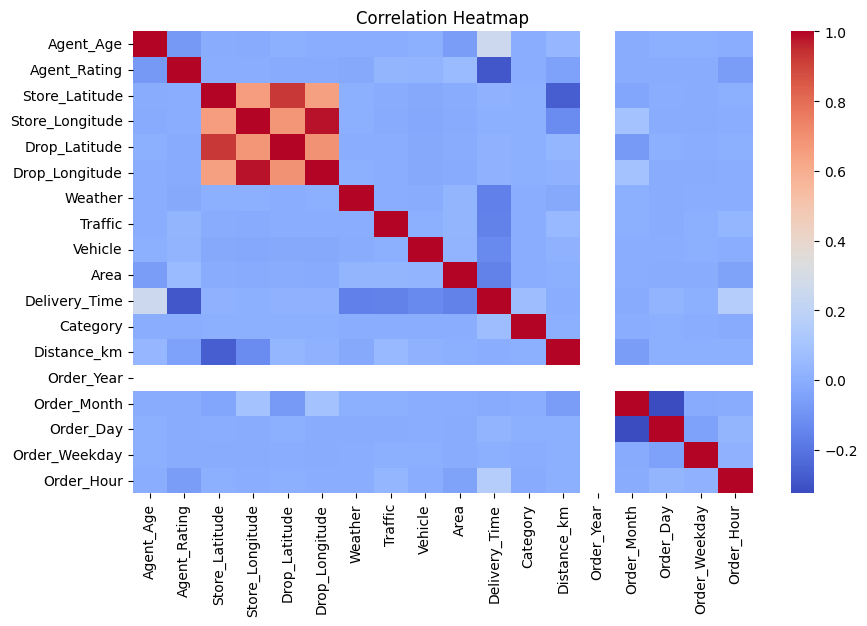

In [45]:
print(df.describe())

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

**Delivery Time Distribution**

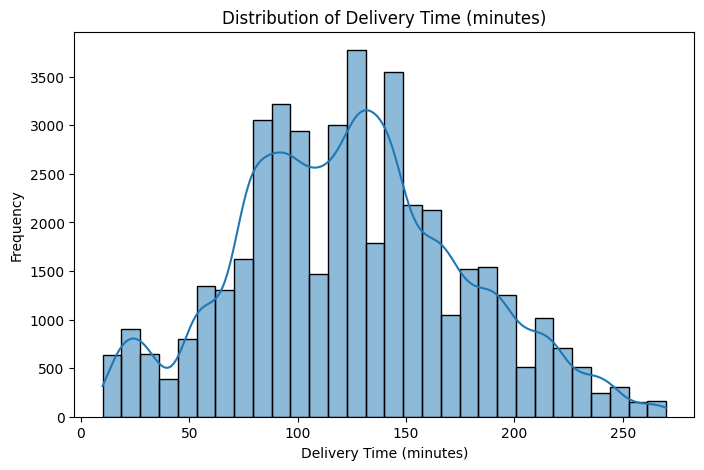

In [46]:
plt.figure(figsize=(8,5))
sns.histplot(df["Delivery_Time"], bins=30, kde=True)
plt.title("Distribution of Delivery Time (minutes)")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Frequency")
plt.show()

**Distance vs Delivery Time**

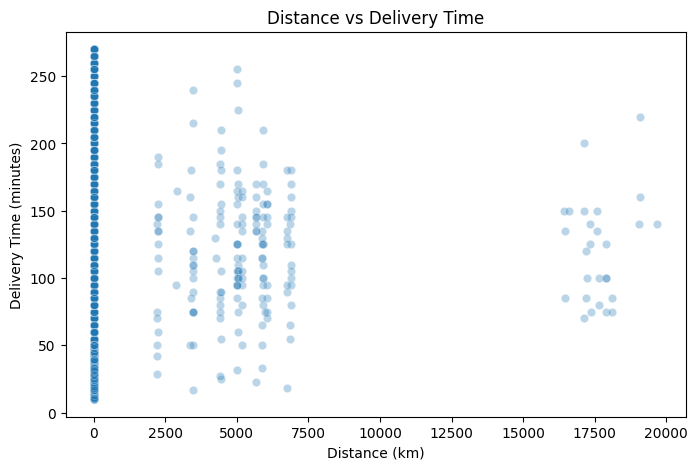

In [47]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Distance_km", y="Delivery_Time", data=df, alpha=0.3)
plt.title("Distance vs Delivery Time")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (minutes)")
plt.show()

**Effect of Traffic on Delivery Time**

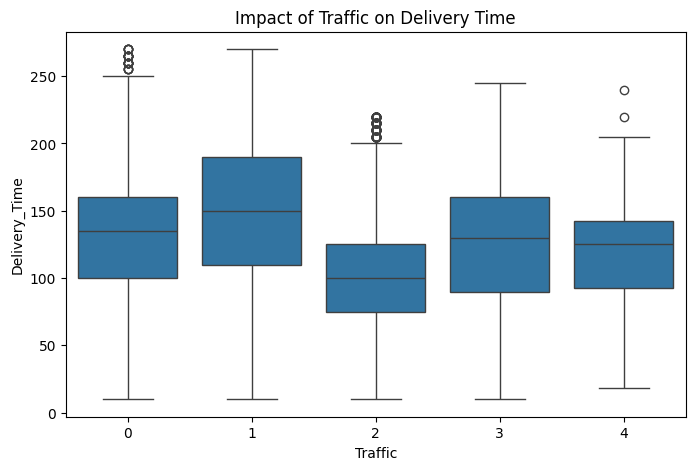

In [48]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Traffic", y="Delivery_Time", data=df)
plt.title("Impact of Traffic on Delivery Time")
plt.show()

**Effect of Weather on Delivery Time**

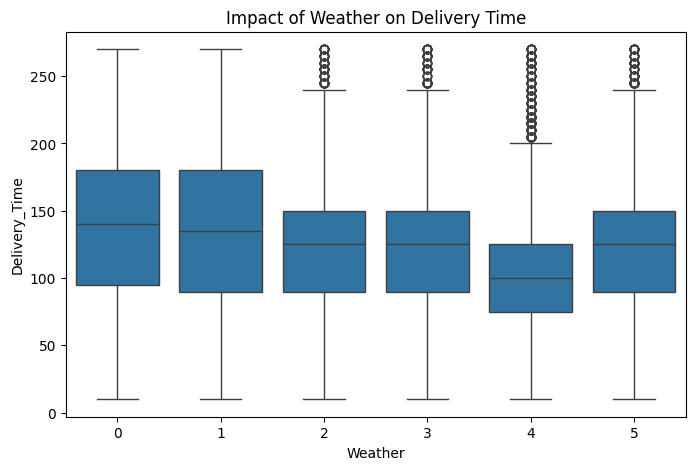

In [49]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Weather", y="Delivery_Time", data=df)
plt.title("Impact of Weather on Delivery Time")
plt.show()

**Agent Performance**

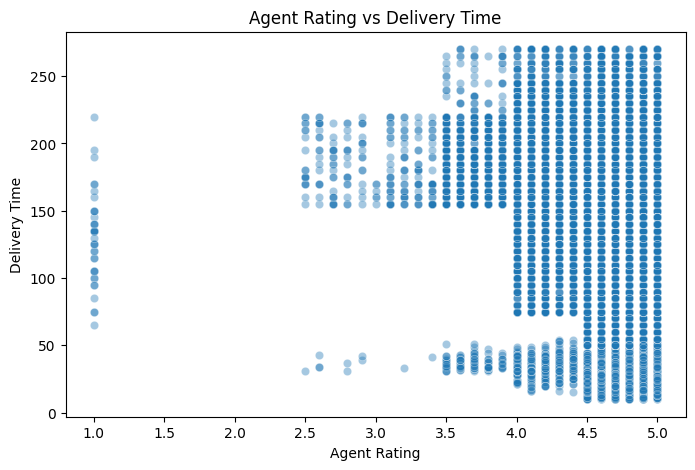

In [50]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Agent_Rating", y="Delivery_Time", data=df, alpha=0.4)
plt.title("Agent Rating vs Delivery Time")
plt.xlabel("Agent Rating")
plt.ylabel("Delivery Time")
plt.show()

**Orders by Hour of Day**

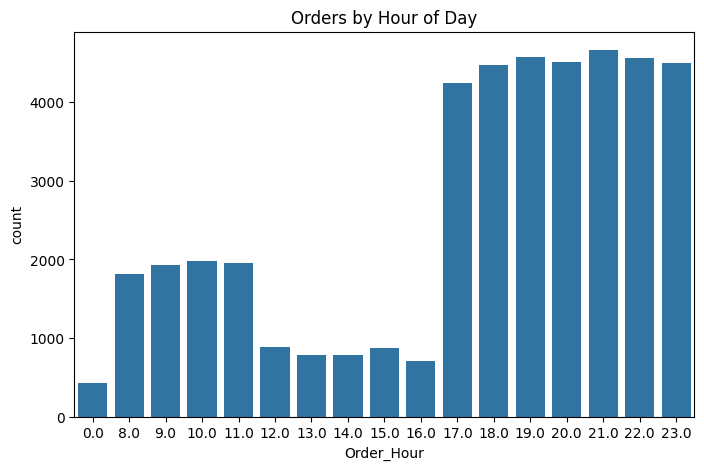

In [51]:
plt.figure(figsize=(8,5))
sns.countplot(x="Order_Hour", data=df)
plt.title("Orders by Hour of Day")
plt.show()

**Insights from EDA**

1. Correlation Heatmap

    - Store & Drop coordinates are highly correlated (makes sense, they are paired).

    - Distance_km has some correlation with Delivery_Time, though not very strong (other factors like traffic/weather also matter).

    - No single feature is dominating → a combination will likely predict best.

2. Delivery Time Distribution

    - Most deliveries are between 60–150 minutes.

    - Few long deliveries (~200–270 min) may be outliers.

    - Distribution is slightly right-skewed → tree-based models (Random Forest Gradient Boosting) will handle this better than Linear Regression.

3. Distance vs Delivery Time

    - We see clusters:

        - Many deliveries are short distance (~0–50 km).

        - A few extreme distances (up to ~20,000 km ) are clearly outliers or data entry errors (likely wrong lat/long). These should be removed/capped.

4. Traffic Impact

    - Higher traffic generally leads to longer delivery times (boxplots shift upwards).

    - This confirms traffic is a useful feature.

5. Weather Impact

    - Bad weather conditions increase delivery time slightly.

    - Not as strong as traffic, but still useful.

6. Agent Rating vs Delivery Time

    - Agents with better ratings (4–5) don’t always deliver faster → rating may not directly reduce time.

    - But very low-rated agents (1–2) often have longer or inconsistent delivery times.

7. Orders by Hour of Day

    - Peak orders are in the evening (17:00–22:00).

    - Lower orders around noon & early morning.

    - Delivery patterns could depend on order time.

**Handling Outliers**

In [52]:
df = df[df["Distance_km"] < 1000]

## **Preparing for Model training**

**Defining Variables and Target**

In [53]:
X = df.drop(columns=["Delivery_Time", "Order_ID", 
                     "Store_Latitude", "Store_Longitude", 
                     "Drop_Latitude", "Drop_Longitude", 
                     "Order_Date", "Order_Time", "Pickup_Time"])
y = df["Delivery_Time"]

**Splitting Dataset**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
print("Training size:", X_train.shape, "Test size:", X_test.shape)

Training size: (34840, 13) Test size: (8711, 13)


**Defining Evaluation Function (RMSE, MAE, R2)**

In [56]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

**Defining Training Function with MLflow Logging**

In [57]:
mlflow.set_experiment("amazon_delivery_prediction")

<Experiment: artifact_location='file:///e:/AI-ML%20Internship/Amazon%20Dilivery%20time/mlruns/595652896739818152', creation_time=1759341180180, experiment_id='595652896739818152', last_update_time=1759341180180, lifecycle_stage='active', name='amazon_delivery_prediction', tags={}>

In [58]:
def train_and_log_model(model, model_name, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit model
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        # Evaluate
        metrics = evaluate_model(y_test, preds)
        
        # Log params (if provided)
        if params:
            mlflow.log_params(params)
        
        # Log metrics
        mlflow.log_metrics(metrics)
        
        # Log model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"{model_name} Results:", metrics)
        return metrics


## **Model Training**

In [59]:
X.isnull().sum()
print("NaNs in training set:\n", X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("NaNs in test set:\n", X_test.isnull().sum()[X_test.isnull().sum() > 0])

NaNs in training set:
 Order_Hour    44
dtype: int64
NaNs in test set:
 Order_Hour    15
dtype: int64


In [60]:
# Filling missing values
for col in X.columns:
    if X[col].dtype in ["float64", "int64"]:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

# Double check
print(X.isnull().sum().sum())


0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19812\3456407531.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19812\3456407531.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

categorical = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
numeric = ["Agent_Age", "Agent_Rating", "Distance_km", "Order_Hour", "Order_Day", "Order_Month", "Order_Weekday", "Order_Year"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)

def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),               # normalize features
        ("model", model)
    ])


1. Linear Regression

In [65]:
lr = make_pipeline(LinearRegression())
results_lr = train_and_log_model(lr, "LinearRegression", X_train, X_test, y_train, y_test)


2025/10/02 01:10:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/02 01:10:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression Results: {'MAE': 25.735844542361964, 'RMSE': np.float64(32.49477377502574), 'R2': 0.6135398681582793}


2. Random Forest

In [62]:
rf_params = {
    "n_estimators": 100,
    "max_depth": None,
    "random_state": 42
}
rf = make_pipeline(RandomForestRegressor(**rf_params))
results_rf = train_and_log_model(rf, "RandomForest", X_train, X_test, y_train, y_test, rf_params)

2025/10/02 01:09:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/02 01:09:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest Results: {'MAE': 17.56874067271266, 'RMSE': np.float64(22.808550558481535), 'R2': 0.8095973286847131}


3. XGBoost

In [63]:
xgb_params = {
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 6,
    "random_state": 42
}
xgb = make_pipeline(XGBRegressor(**xgb_params))
results_xgb = train_and_log_model(xgb, "XGBoost", X_train, X_test, y_train, y_test, xgb_params)

2025/10/02 01:09:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/02 01:09:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost Results: {'MAE': 17.74884033203125, 'RMSE': np.float64(22.7930594605093), 'R2': 0.8098558783531189}


**Comparing Results**

In [66]:
results = {
    "Linear Regression": results_lr,
    "Random Forest": results_rf,
    "XGBoost": results_xgb
}

results_df = pd.DataFrame(results).T
print(results_df)

                         MAE       RMSE        R2
Linear Regression  25.735845  32.494774  0.613540
Random Forest      17.568741  22.808551  0.809597
XGBoost            17.748840  22.793059  0.809856


**Freezing the best Model**

In [67]:
joblib.dump(xgb, "models/best_model.pkl")

print("Best model saved as models/best_model.pkl")

Best model saved as models/best_model.pkl


## **Conclusion**

The final system successfully predicts delivery times by combining feature engineering, machine learning, and an interactive user interface.

- The pipeline approach ensured that preprocessing (encoding, imputation, scaling) and model prediction were tightly integrated, avoiding mismatched features or errors.

- The Streamlit app provides a user-friendly interface, allowing non-technical users (such as logistics managers) to input details and instantly get predictions.

- By integrating MLflow, different models can be logged, compared, and tracked efficiently.

- The solution demonstrates how data-driven decision making can improve logistics efficiency, agent performance monitoring, and customer satisfaction in e-commerce delivery systems.

In conclusion, this project proves that machine learning can be leveraged in real-world logistics to enhance delivery accuracy, optimize operations, and support better customer experiences.